<a href="https://colab.research.google.com/github/themis-ai/capsa/blob/ed-notebooks/notebooks/4_Ensemble-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Eliminate Epistemic Uncertainty with `capsa` 
###  A Python Library for Deep Learning Model Risk Management

--------------------

#### Section 1: What is Epistemic Uncertainty? 

Epistemic uncertainty reflects the uncertainty that is inherent in a model's predictions due to the limited amount of information that the model has. This is in contrast to aleatoric uncertainty, which is uncertainty that arises from randomness or inherent noise in the data.

Knowing the epistemic uncertainty of a model can be important for a number of reasons: 

1. It can help us to understand the limitations of the model and know when it is likely to make inaccurate predictions. This can be useful for identifying situations where the model should be used with caution, or where it may not be appropriate to use it at all.

2. Knowing the epistemic uncertainty of a model can also help us to identify areas where the model is unsure of its predictions. This can be useful for identifying areas where the model may benefit from additional training data, or where it may be necessary to use a different model altogether.

------------------------------

#### Section 2: ``capsa`` (a Python Library for Mitigating Uncertainty)

Capsa is a convenient model wrapping tool. It wraps around predefined Keras models, adding the ability to perform risk analysis on the predictions made by those models, and therefore letting developers make more informed decisions about how to use it in their applications.

``capsa`` allows users to select a MetricWrapper that augments model with a corresponding risk-metric:

- **Representation Bias**: Bias of a dataset that exists in a target feature space in the model 
    - HistogramWrapper
- **Aleatoric Uncertainty**: Uncertainty that results from randomness or inherent noise in the data
    - MVEWrapper
- **Epistemic Uncertainty**: Uncertainty in a model's predictions due to model limitations or limited data
    - DropoutWrapper
    - EnsembleWrapper
    - VAEWrapper


-----------------------

#### Section 3: ``EnsembleWrapper()``

<img src="https://github.com/themis-ai/capsa/blob/ed-notebooks/notebooks/EnsembleWrapper.png?raw=1">

``EnsembleWrapper()`` takes in a model and copies the architecture ``num_members`` times. This new ensemble architecture is parallelizable with tensorflow. Since each individual model (ensemble) has different initialization weights, they will converge towards different points in the loss surface as they are being trained. Therefore, given an input, each of these ensembles will output different predictions. The variance of all ensemble outputs gives us the epistemic uncertainty, **R**.

-----------------------------------------

#### Section 4: How to use ``capsa``

##### Installation and Import

First of all, let's install ``capsa`` to our work environment with ``pip install capsa``.

In [ ]:
!pip install capsa
!wget https://github.com/themis-ai/capsa/raw/main/notebooks/helper.py

Then, we can import all the necessary libraries, as well as the `EnsembleWrapper` class.

In [ ]:
from matplotlib import pyplot as plt
import tensorflow as tf
import helper
from capsa import EnsembleWrapper

##### Loading a Dataset

2. You would have your own training and test dataset ready.

In [ ]:
(x_train, y_train), (x_test, y_test) = helper.generate_moon_data_classification()

3. You might want to visualize your own dataset to get a better understanding of your own data. So you plot your training dataset into a graph.

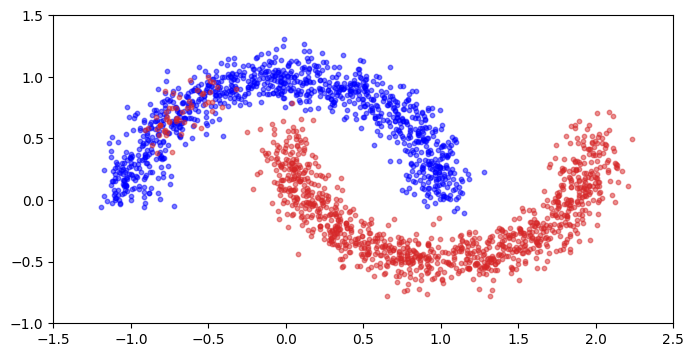

In [ ]:
helper.plot_for_moons(x_train, y_train)

4. Just like in your normal workflow, you'd have your own pre-defined model.

In [ ]:
user_model = helper.generate_model_mve_classification()

##### Wrapping Keras Model with EnsembleWrapper()

So far, we've only dealt with tensorflow and defined our model as a Keras.Model variable. We can pass this variable as a parameter to `EnsembleWrapper(model,num_members=10)`, which augments the model to become risk-aware. The new ``wrapped_model`` variable can be used just like the initial model during training and inference.  

In [ ]:
wrapped_model = EnsembleWrapper(user_model,num_members=10)

##### Compiling and Fitting

Just like how we might do in a Keras model, we will predefine an optimizer as well as a loss_function to use. We can compile our wrapped model using keras provided tools.  

In [ ]:
wrapped_model.compile(
            optimizer=tf.keras.optimizers.Adam(),
            loss=tf.keras.losses.BinaryCrossentropy(),
            metrics=[tf.keras.metrics.BinaryAccuracy()]
                     )

Now, let's fit our model with the training data that we initially loaded. As it's fitting, you can manually inspect the loss metrics of each ensemble.

In [ ]:
wrapped_model.fit(x_train,tf.one_hot(y_train,2),epochs=3)

Epoch 1/3
1313/1313 [==============================] - 14s 6ms/step - usermodel_0_loss: 0.3939 - usermodel_0_binary_accuracy: 0.8311 - usermodel_1_loss: 0.3978 - usermodel_1_binary_accuracy: 0.8311 - usermodel_2_loss: 0.4295 - usermodel_2_binary_accuracy: 0.8311 - usermodel_3_loss: 0.3667 - usermodel_3_binary_accuracy: 0.8310 - usermodel_4_loss: 0.4082 - usermodel_4_binary_accuracy: 0.8310 - usermodel_5_loss: 0.4118 - usermodel_5_binary_accuracy: 0.8310 - usermodel_6_loss: 0.4103 - usermodel_6_binary_accuracy: 0.8310 - usermodel_7_loss: 0.3932 - usermodel_7_binary_accuracy: 0.8311 - usermodel_8_loss: 0.3661 - usermodel_8_binary_accuracy: 0.8311 - usermodel_9_loss: 0.3550 - usermodel_9_binary_accuracy: 0.8312
Epoch 2/3
1313/1313 [==============================] - 7s 5ms/step - usermodel_0_loss: 0.1847 - usermodel_0_binary_accuracy: 0.9219 - usermodel_1_loss: 0.1997 - usermodel_1_binary_accuracy: 0.9219 - usermodel_2_loss: 0.2788 - usermodel_2_binary_accuracy: 0.9219 - usermodel_3_loss: 

Now that our wrapped model has been trained, we can continue on how to use it.

---

##### Inference

Note: In the example below, we used a function called ``get_grid()`` . We used this function to generate samples in the input space. These samples are passed to our model to visually observe epistemic uncertainty in this space. 

In [ ]:
mesh_grid = helper.get_grid()
output = wrapped_model(mesh_grid)

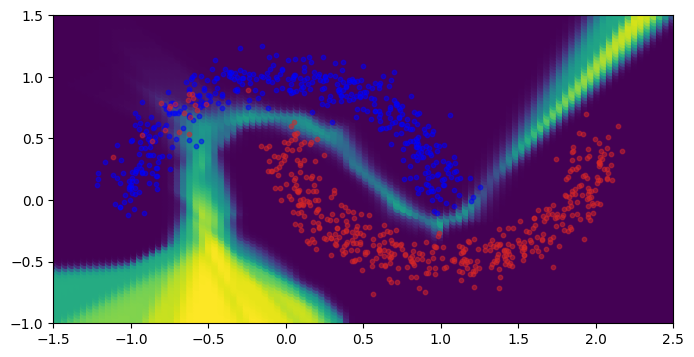

In [ ]:
helper.plot_ensemble_classification(output,mesh_grid,x_test,y_test)

What we can see here is that ensembles have high variance in more yellow locations in this space, giving us a clear understanding of the epistemic uncertainty of our model.